https://lilianweng.github.io/lil-log/2021/07/11/diffusion-models.html#:~:text=Diffusion%20models%20are%20a%20new,to%20analytically%20evaluate%20the%20distribution.&text=Diffusion%20models%20are%20inspired%20by%20non%2Dequilibrium%20thermodynamics.

In [14]:
from sklearn.datasets import make_swiss_roll
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from typing import Tuple
import torch.distributions as D
import math
from abc import abstractmethod
import torch.nn.functional as F

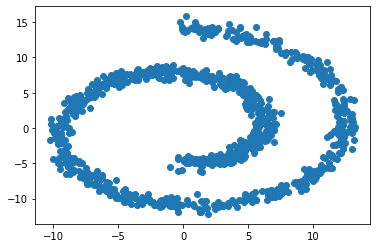

In [2]:
class TargetDistribution:
    
    def __init__(self, noise: float = 0.5):
        self.noise = noise
        
    def sample(self, sample_shape: Tuple[int]):
        x_0, _ = make_swiss_roll(n_samples=sample_shape[0], noise=self.noise)  # 3D
        return x_0[:, [0,2]]  # 2D
    
q = TargetDistribution()
x_0 = q.sample(sample_shape=(1000,))
plt.scatter(*x_0.T)
plt.show()

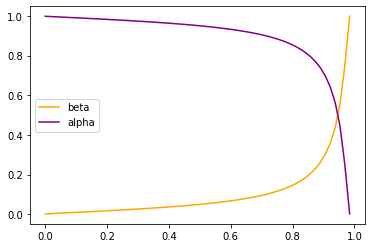

In [11]:
def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

T = 64
betas = betas_for_alpha_bar(
    T,
    lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
)
alphas = 1 - betas
plt.plot([t/T for t in range(len(betas))], betas, label='beta', c='orange')
plt.plot([t/T for t in range(len(betas))], alphas, label='alpha', c='purple')
plt.legend()
plt.show()

In [23]:
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

torch.Size([64])
torch.Size([64, 2])


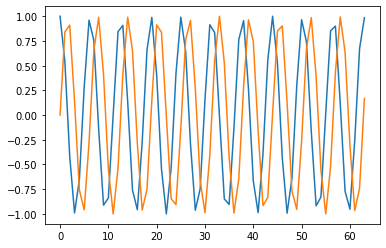

In [21]:
def timestep_embedding(timesteps, dim, max_period=1000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


timesteps = torch.arange(0.0, T, step=1)
print(timesteps.shape)
emb = timestep_embedding(timesteps, dim=2)
print(emb.shape)
plt.plot(timesteps, emb)
plt.show() 

In [32]:
class ResBlock(TimestepBlock):
    
    def __init__(
        self,
        in_channels,
        emb_channels,
        out_channels,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.emb_channels = emb_channels
        self.out_channels = out_channels
        
        self.in_layers = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.SiLU(inplace=True),
            nn.Linear(in_channels, out_channels),
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(inplace=True),
            nn.Linear(
                emb_channels,
                out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            nn.BatchNorm1d(out_channels),
            nn.SiLU(inplace=True),
            nn.Linear(
                out_channels,
                out_channels,
            ),
        )
        if out_channels == in_channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Linear(in_channels, out_channels)
        
    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
            
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h
    
resblock = ResBlock(in_channels=8, emb_channels=16, out_channels=12)
x = torch.randn(3, 8)
timesteps = torch.tensor([1, 5, 17])
emb = timestep_embedding(timesteps, dim=16)
out = resblock(x, emb)
print(out.shape)

torch.Size([3, 12])


In [34]:
def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_parameters(model):
    print(model.__class__.__name__, count_parameters(model))

class DiffusionNet(nn.Module):
    
    def __init__(self, in_channels, model_channels, out_channels):
        super().__init__()
        self.model_channels = model_channels
        
        emb_channels = 4 * model_channels
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, emb_channels),
            nn.SiLU(inplace=True),
            nn.Linear(emb_channels, emb_channels),
        )
        
        self.blocks = TimestepEmbedSequential(
            nn.Linear(in_channels, model_channels),
            ResBlock(model_channels, emb_channels, 2 * model_channels),
            ResBlock(2 * model_channels, emb_channels, model_channels),
        )
        self.out = nn.Sequential(
            nn.BatchNorm1d(model_channels),
            nn.SiLU(inplace=True),
            zero_module(nn.Linear(model_channels, out_channels)),
        )
        
    def forward(self, x_t, t):
        emb = self.time_embed(timestep_embedding(t, self.model_channels))
        h = self.blocks(x_t, emb)
        return self.out(h)
    
z_theta = DiffusionNet(in_channels=2, model_channels=16, out_channels=2)
print_parameters(z_theta)
x_t = torch.randn(3, 2)
t = torch.tensor([7, 5, 9])
out = z_theta(x_t, t)
print(out.shape)

DiffusionNet 12146
torch.Size([3, 2])


In [4]:
# https://github.com/openai/improved-diffusion/blob/783b6740edb79fdb7d063250db2c51cc9545dcd1/improved_diffusion/unet.py#L35
num_steps = 100
batch_size = 8
T = 32
q = TargetDistribution()
sample = q.sample(sample_shape=(1000,))
mu = sample.mean()
sigma = sample.std()

def normalize(x, mu, sigma):
    return (x - mu) / sigma

def criterion(x_0, z_theta, z_t, alpha_bar_t, t):
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * z_t
    L_simple_t = torch.sum(torch.square(z_t - z_theta(x_t, t)), dim=1).mean()
    return L_simple_t

def training_loop(num_steps, z_theta, optimizer, q):
    noise = D.Normal(torch.zeros(2), torch.ones(2))
    time = D.Uniform(1, T)
    
    for step in num_steps:
        x_0 = q.sample(sample_shape=(batch_size,))
        x_0 = normalize(x_0, mu, sigma)
        z_t = noise.sample(sample_shape=(batch_size,))
        t = time.sample(sample_shape=(batch_size,))
        
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(x_0, z_theta, z_t, alpha_bar_t, t)
        loss.backward()
        optimizer.step()